In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
def standard_units(any_numbers):
    """Convert any array of numbers to standard units."""
    return (any_numbers - np.average(any_numbers)) / np.std(any_numbers)

# Below, t is a table; x and y are column indices or labels.

def correlation(t, x, y):
    """Return the correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of the regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

def fitted_values(t, x, y):
    """The fitted values along the regression line."""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * t.column(x) + b


# Graphing the Residuals

In [3]:
neo = Table.read_table('neo.csv')
neo

V relative (km/s),V infinity (km/s),H (mag),CA Distance LD,CA Distance AU
12.88,12.87,25.4,5.88,0.01512
13.31,13.24,27.5,1.11,0.00285
4.77,4.75,27.9,11.07,0.02845
8.44,8.42,27.2,7.28,0.01871
5.46,5.33,29.6,1.53,0.00394
10.04,10.02,27.2,5.94,0.01527
17.25,17.23,27.7,3.01,0.00773
8.28,8.25,26.9,4.27,0.01098
7.96,7.9,28.4,2.07,0.00531
11.59,11.59,25,16.19,0.04159


In [4]:
size_velocity = neo.select('H (mag)', 'V relative (km/s)')
size_velocity

H (mag),V relative (km/s)
25.4,12.88
27.5,13.31
27.9,4.77
27.2,8.44
29.6,5.46
27.2,10.04
27.7,17.25
26.9,8.28
28.4,7.96
25,11.59


In [5]:
dist_v = size_velocity.with_column("fitted y value", fitted_values(size_velocity, 0, 1))
dist_v

H (mag),V relative (km/s),fitted y value
25.4,12.88,8.98944
27.5,13.31,6.81812
27.9,4.77,6.40454
27.2,8.44,7.12831
29.6,5.46,4.6468
27.2,10.04,7.12831
27.7,17.25,6.61133
26.9,8.28,7.4385
28.4,7.96,5.88756
25,11.59,9.40303


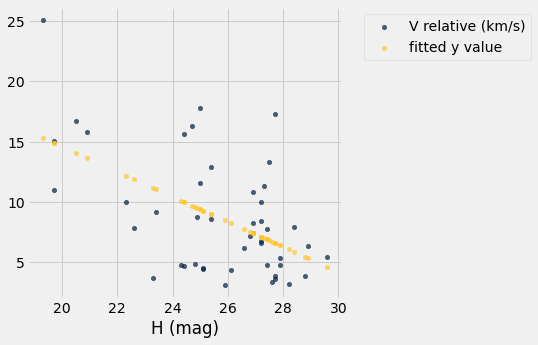

In [6]:
dist_v.scatter(0)

In [7]:
def residuals(t, x, y):
    return t.column(y) - fitted_values(t, x, y)

In [8]:
residual_tbl = dist_v.with_column('Residual', residuals(size_velocity, 0, 1))
residual_tbl

H (mag),V relative (km/s),fitted y value,Residual
25.4,12.88,8.98944,3.89056
27.5,13.31,6.81812,6.49188
27.9,4.77,6.40454,-1.63454
27.2,8.44,7.12831,1.31169
29.6,5.46,4.6468,0.813195
27.2,10.04,7.12831,2.91169
27.7,17.25,6.61133,10.6387
26.9,8.28,7.4385,0.8415
28.4,7.96,5.88756,2.07244
25,11.59,9.40303,2.18697


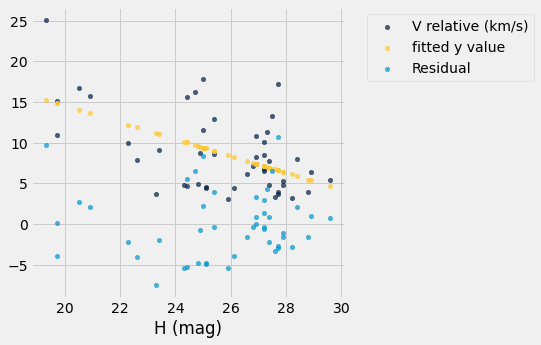

In [9]:
residual_tbl.scatter(0)

In [10]:
def plot_residuals(t, x, y):
    with_residuals = t.with_columns(
        'Fitted', fitted_values(t, x, y),
        'Residual', residuals(t, x, y)
    )
    with_residuals.select(x, y, 'Fitted').scatter(0)
    with_residuals.scatter(x, 'Residual');
    plots.plot((18, 30), (0, 0), linestyle = "--", linewidth = 3)

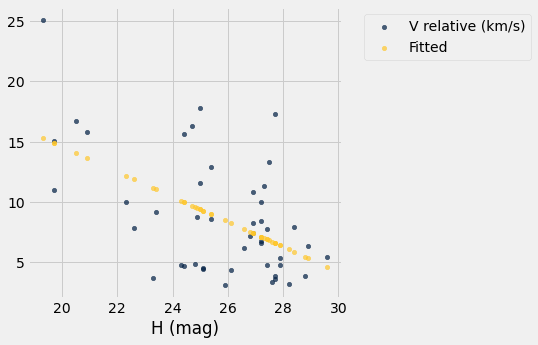

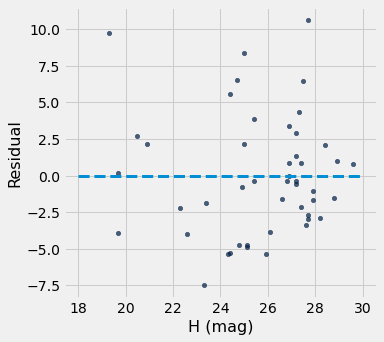

In [11]:
plot_residuals(residual_tbl, 0, 1)

# Numerical Diagnostics

In [12]:
def plot_fitted(t, x, y):
    tbl = t.select(x, y)
    tbl.with_columns('Fitted Value', fitted_values(t, x, y)).scatter(0)

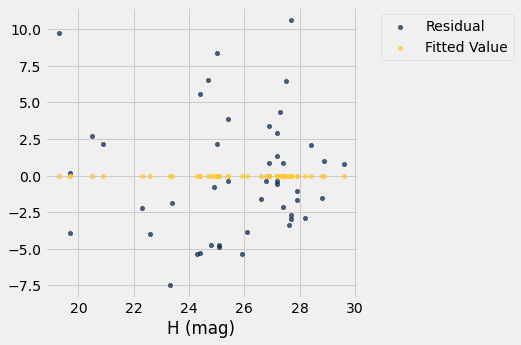

In [13]:
plot_fitted(residual_tbl, 0, 3)

In [14]:
## 1. correlation coefficients
r_res = correlation(residual_tbl, 0, 3)
r_res

2.2676895822130855e-16

In [15]:
## 2. average of residuals
residual_values = residual_tbl.column('Residual')
np.mean(residual_values)

-2.0976128635471044e-15

In [16]:
## 3. standard deviation of residuals 
sd_res = np.std(residual_values)
sd_res

4.099126154456977

In [17]:
## sd of residuals = sq root of 1 - r **2 * sd of y
(1- r_res**2)**0.5  * sd_res

4.099126154456977

In [18]:
## Variance 
np.var(residual_tbl.column(1))

23.75804182888185

In [19]:
np.var(fitted_values(residual_tbl, 0, 1)) + np.var(residual_values)

23.758041828881847

In [20]:
np.var(fitted_values(residual_tbl, 0, 1)) / np.var(size_velocity.column(1))

0.2927516774666754

In [21]:
r = correlation(size_velocity, 0, 1)
r**2

0.29275167746667524

In [22]:
np.sqrt(np.var(fitted_values(size_velocity, 0, 1)) / np.var(size_velocity.column(1)))

0.5410653171907024

In [23]:
r

-0.5410653171907023